In [1]:
import draw
import data_Manager
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from HyperParameters import HP
import train_utility as tu
import generate as g

Using TensorFlow backend.


In [3]:
# model for predicting the inital state 
batch_z = tf.keras.Input(shape=(HP.latent_dim,))
initial_state = tf.keras.layers.Dense(units=(2*HP.dec_hidden_size), activation='tanh', name = "decoder_init_stat")(batch_z)
latent_to_hidden_state_model = tf.keras.Model(inputs=batch_z, outputs=initial_state)
latent_to_hidden_state_model.load_weights("model_weight.h5", by_name = True)
latent_to_hidden_state_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
decoder_init_stat (Dense)    (None, 1024)              263168    
Total params: 263,168
Trainable params: 263,168
Non-trainable params: 0
_________________________________________________________________


In [4]:
# create the LSTM for generating
"""
We have 3 input tensor. The input of the LSTM and the hidden states 
"""
decoder_input = tf.keras.Input(shape=(1, 5 + HP.latent_dim))
initial_h_input = tf.keras.Input(shape=(HP.dec_hidden_size,))
initial_c_input = tf.keras.Input(shape=(HP.dec_hidden_size,))
# now the LSTM
decoderLSTM = tf.keras.layers.LSTM(HP.dec_hidden_size, recurrent_dropout=HP.rec_dropout, 
                                    return_sequences=True, return_state=True, name = "LSTM_decoder")

# creation of the LSTM
decoder_output, h_new, c_new = decoderLSTM(decoder_input, initial_state = [initial_h_input, initial_c_input])
# dense to output. THe dimention is, as explained in the paper equal to 3 + 6*M
# 6 times M= number of mixture 
output_dimention = (3 + HP.M * 6)
distribution_output = tf.keras.layers.Dense(output_dimention, name = "output_layer")(decoder_output)

# Now we load the weights from the trained model
generator = tf.keras.models.Model([decoder_input, initial_h_input, initial_c_input], outputs =[ distribution_output , h_new, c_new])
generator.summary()
generator.load_weights("model_weight.h5", by_name = True)
generator.build(tf.TensorShape([1, None])) 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1, 261)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
LSTM_decoder (LSTM)             [(None, 1, 512), (No 1585152     input_3[0][0]                    
                                                                 input_4[0][0]              

In [5]:
seq =  g.generate_sketch(generator, latent_to_hidden_state_model)

new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)
new_elem shape
(5,)


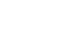

In [8]:
draw.draw_strokes(seq, svg_filename="stroke_1.svg")